In [1]:
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

import pathlib
import numpy as np
import pandas as pd

SEQUENCE_LENGTH = 64  # Evaluate on sequences of 64 days
LOOKUP_SIZE = 7  # Predict next 7 days
FEATURES = ['new_cases', 'negative_avg', 'positive_avg', 'total_count', 'neutral_avg', '#RT']


                     #RT
date                    
2020-01-22 00:00:00   84
2020-01-22 01:00:00   72
2020-01-22 02:00:00  162
2020-01-22 03:00:00  224
2020-01-22 04:00:00  163
            negative_avg  positive_avg  neutral_avg  total_count  new_cases  \
date                                                                          
2020-01-28      0.432558      0.040581     0.526861     0.049785   0.000002   
2020-01-29      0.460969      0.040510     0.498521     0.089913   0.000003   
2020-01-30      0.454047      0.043494     0.502458     0.135770   0.000003   
2020-01-31      0.459418      0.044111     0.496471     0.163636   0.000005   
2020-02-01      0.466455      0.047627     0.485918     0.151167   0.000006   

                 #RT  
date                  
2020-01-28  0.000000  
2020-01-29  0.045351  
2020-01-30  0.094245  
2020-01-31  0.127599  
2020-02-01  0.123248  


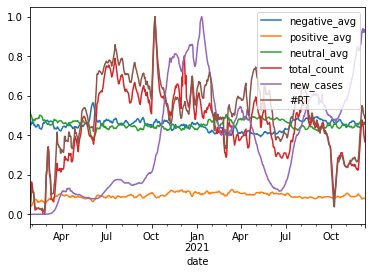

In [2]:
SENTIMENT_DATA = pathlib.Path('../data/Sent_by_day.csv')
TWEET_DATA = pathlib.Path('../data/SUMMARY_day_main.csv')
COVID_DATA = pathlib.Path('../data/owid-covid-data.csv')
PROCESSED_DATA = pathlib.Path('../data/processed_data.csv')

daily_max = 0
daily_min = 0

def data_processing():
    global daily_max, daily_min
    # Check if processed data file exists
    # if PROCESSED_DATA.exists():
    #     return pd.read_csv(PROCESSED_DATA)

    # Otherwise, process raw data
    sentiment_data = pd.read_csv(SENTIMENT_DATA, index_col=0, parse_dates=[['Year', 'Month', 'Day']])
    sentiment_data.index.rename('date', inplace=True)
    sentiment_data.drop(['Unnamed: 0'], axis=1, inplace=True)
    negative_data = sentiment_data[sentiment_data['Sentiment'] == 'negative']
    positive_data = sentiment_data[sentiment_data['Sentiment'] == 'positive']
    neutral_data = sentiment_data[sentiment_data['Sentiment'] == 'neutral']
    sentiment_data = pd.concat([negative_data, positive_data, neutral_data], axis=1, join="inner")
    sentiment_data = sentiment_data.drop(['Sentiment'], axis=1)
    sentiment_data.columns = ['negative_count', 'negative_avg', 'positive_count', 'positive_avg', 'neutral_count', 'neutral_avg']
    sentiment_data['total_count'] = sentiment_data.negative_count + sentiment_data.positive_count + sentiment_data.neutral_count
    sentiment_data.drop(['negative_count', 'positive_count', 'neutral_count'], axis=1, inplace=True)
    sentiment_data = sentiment_data.groupby(['date']).sum().rolling(7).mean()

    tweet_data = pd.read_csv(TWEET_DATA,
                             index_col=0,
                             parse_dates=['Date'],
                             date_parser=lambda x: pd.to_datetime(x, format='%Y_%m_%d_%H'),
                             usecols=['Date', '#RT']
                             )
    tweet_data.index.rename('date', inplace=True)
    print(tweet_data.head())
    tweet_data = tweet_data.groupby(pd.Grouper(freq='1D')).sum().rolling(7).mean()

    daily_data = pd.read_csv(COVID_DATA, index_col=3, parse_dates=['date'])
    daily_data = daily_data[daily_data.continent.isin(['Europe', 'North America'])]
    daily_data = daily_data['new_cases'].groupby(['date']).sum().rolling(7).mean()

    daily_data = daily_data[daily_data.index >= pd.to_datetime('2020-01-28')]
    daily_data = daily_data[daily_data.index <= pd.to_datetime('2021-12-09')]

    sentiment_data = sentiment_data[sentiment_data.index >= pd.to_datetime('2020-01-28')]
    sentiment_data = sentiment_data[sentiment_data.index <= pd.to_datetime('2021-12-09')]

    tweet_data = tweet_data[tweet_data.index >= pd.to_datetime('2020-01-28')]
    tweet_data = tweet_data[tweet_data.index <= pd.to_datetime('2021-12-09')]

    # Normalizing data
    daily_max = daily_data.max()
    daily_min = daily_data.min()
    daily_data = (daily_data - daily_min) / (daily_max - daily_min)

    total_max = sentiment_data.total_count.max()
    total_min = sentiment_data.total_count.min()
    sentiment_data['total_count'] = (sentiment_data['total_count'] - total_min) / (total_max - total_min)

    tweet_max = tweet_data.max()
    tweet_min = tweet_data.min()
    tweet_data = (tweet_data - tweet_min) / (tweet_max - tweet_min)

    ret = pd.concat((sentiment_data, daily_data, tweet_data), axis=1)
    ret.to_csv(PROCESSED_DATA)
    return ret

data = data_processing()
print(data.head())
data.plot()
plt.show()

In [3]:
def create_model(sequence_length, n_features, units=50, n_layers=5, dropout=0.3,
                loss="mean_squared_error", optimizer="rmsprop"):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
                model.add(GRU(units, return_sequences=True, input_shape=(sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
                model.add(GRU(units, return_sequences=False))
        else:
            # hidden layers
                model.add(GRU(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss=loss, metrics=[loss], optimizer=optimizer)
    return model

In [4]:
import os
import time

model_name = "model_" + time.strftime("%Y%m%d-%H%M%S")
model = create_model(sequence_length=SEQUENCE_LENGTH, n_features=len(FEATURES), units=300, n_layers=5, dropout=0.3,
                loss=losses.MeanSquaredError(), optimizer=optimizers.Adam(learning_rate=0.001))
model.summary()
checkpoint = ModelCheckpoint(os.path.join("../models", model_name), monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_freq=10)

# Split data into SEQUENCE_LENGTH days
def split_data(data):
    X = []
    y = []
    for i in range(len(data) - SEQUENCE_LENGTH - LOOKUP_SIZE):
        X.append(data[i:i + SEQUENCE_LENGTH][FEATURES])
        y.append(data[i + SEQUENCE_LENGTH + LOOKUP_SIZE - 1:i + SEQUENCE_LENGTH + LOOKUP_SIZE]['new_cases'])

    return np.array(X), np.array(y)

data_x, data_y = split_data(data)
TEST_SIZE = int(len(data_x) * 0.15)
train_x = tf.convert_to_tensor(data_x[:-TEST_SIZE])
train_y = tf.convert_to_tensor(data_y[:-TEST_SIZE])
test_x = tf.convert_to_tensor(data_x[-TEST_SIZE:])
test_y = tf.convert_to_tensor(data_y[-TEST_SIZE:])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64, 300)           277200    
                                                                 
 dropout (Dropout)           (None, 64, 300)           0         
                                                                 
 gru_1 (GRU)                 (None, 64, 300)           541800    
                                                                 
 dropout_1 (Dropout)         (None, 64, 300)           0         
                                                                 
 gru_2 (GRU)                 (None, 64, 300)           541800    
                                                                 
 dropout_2 (Dropout)         (None, 64, 300)           0         
                                                                 
 gru_3 (GRU)                 (None, 64, 300)           5

In [5]:
history = model.fit(train_x, train_y,
                    epochs=1000,
                    batch_size=32,
                    validation_data=(test_x, test_y),
                    # callbacks=[checkpoint]
                    )

Epoch 1/1000
17/17 [==============================] - 39s 718ms/step - loss: 0.0719 - mean_squared_error: 0.0699 - val_loss: 0.0409 - val_mean_squared_error: 0.0437

In [6]:
# model.save('../models/' + model_name + '_final.h5')

50110.697231020094


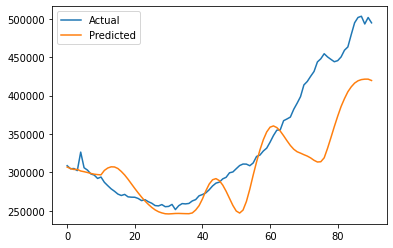

In [7]:
results = model.predict(test_x)
results = results * (daily_max - daily_min) + daily_min
test_y = test_y * (daily_max - daily_min) + daily_min
print(sqrt(mean_squared_error(test_y, results)))
plt.plot(test_y, label='Actual')
plt.plot(results, label='Predicted')
plt.legend()
plt.show()

In [8]:
a = model.predict(np.array(data[-SEQUENCE_LENGTH:][FEATURES]).reshape(1, SEQUENCE_LENGTH, len(FEATURES)))
print(data[-1:].index + pd.Timedelta(days=LOOKUP_SIZE))
print(a * (daily_max - daily_min) + daily_min)


DatetimeIndex(['2021-12-16'], dtype='datetime64[ns]', name='date', freq=None)
[[403255.62]]
